# NEURAL NETWORK with K-MEANS for MNIST

#### Import

In [1]:
import sys
import time
import pickle
import gzip
from random import randint
from scipy import misc
from scipy import special
import scipy.ndimage
from scipy.sparse import csr_matrix
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans,MiniBatchKMeans
import matplotlib.pyplot as plt
import json
import collections
import math
import sys

#### Initial Settings

In [2]:
DATA_PATH = 'data/mnist/'

IMAGES_TRAIN = 'data_training'
IMAGES_TEST = 'data_testing'

RANDOM_SEED = 42
N_CLASSES = 10
N_FEATURES = 28 * 28

In [3]:
data_training = DATA_PATH+IMAGES_TRAIN
data_testing = DATA_PATH+IMAGES_TEST
ft = gzip.open(data_training, 'rb')
TRAINING = pickle.load(ft)
ft.close()
ft = gzip.open(data_testing, 'rb')
TESTING = pickle.load(ft)
ft.close()

## Neural Network

In [258]:
class Neural_Network:
    
    def __init__(self, neurons, batchsize, stop_function, stop_parameter):
        self.input_size = N_FEATURES
        self.output_size = N_CLASSES
        self.neurons = neurons
        self.batchsize = batchsize
        self.stop_f = stop_function
        self.stop_p = stop_parameter
        self.best = 0.
        self.same = 0
        self.iteration = 0
        
        # Standardize random weights
        np.random.seed(RANDOM_SEED)
        hidden_layer = np.random.rand(self.neurons, self.input_size + 1) / self.neurons
        output_layer = np.random.rand(self.output_size, self.neurons + 1) / self.output_size
        self.layers = [hidden_layer, output_layer]

    def train(self, training, testing):
        
        accu = [0.,0.]
        
        # Batch Setting
        len_batch_train = len(training[0])
        len_batch_test = len(testing[0])
        if(self.batchsize > 0 and self.batchsize <= 1):
            len_batch_train = int(np.ceil(len_batch_train * self.batchsize))
            len_batch_test = int(np.ceil(len_batch_test * self.batchsize))
        
        # Start prints 
        self.start_time = dt.datetime.now()
        print('-- Training Session Start (%s) --' % (self.start_time))
        typeTrainingPrint = "Stop Function: "    
        if self.stop_f == 0:
            typeTrainingPrint += str(self.stop_p)+" epochs"
        elif self.stop_f == 1:
            typeTrainingPrint += str(self.stop_p)+" epoch(s) w/o improvements"
        elif self.stop_f == 2:
            typeTrainingPrint += "improvements below "+str(self.stop_p)+"%"
        print('\nNeurons: %d\nBatch Train: %d\nBatch Test: %d\n%s\n' % (self.neurons,len_batch_train,len_batch_test,typeTrainingPrint))
        
        # Divide training and testing batches
        test_output = testing[0:len_batch_test][0:len_batch_test]
        inputs = training[0][0:len_batch_train]
        targets = np.zeros((len_batch_train, 10))
        for i in range(len_batch_train):
            targets[i, training[1][i]] = 1

        # Performs iterations
        while not self.is_stop_function_enabled(accu[1]):
            for input_vector, target_vector in zip(inputs, targets):
                self.backpropagate(input_vector, target_vector)
            
            # Accuracy
            accu = self.accu(test_output)
            self.iteration += 1
            
            # Messages
            if (self.iteration == 1 or self.iteration % 10 == 0):
                self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))
                
        # Print last epoch
        if (self.iteration % 10 != 0):
            self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))

        # Final message
        print('\n-- Training Session End (%s) --' % (dt.datetime.now()))

    def feed_forward(self, input_vector):
        outputs = []
        for layer in self.layers:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(layer, input_with_bias)
            output = special.expit(output)
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def backpropagate(self, input_vector, target):
        c = 1./math.sqrt(self.iteration + 10)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        self.layers[-1] -= c*np.outer(output_deltas, np.append(hidden_outputs, 1))

        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * np.dot(np.delete(self.layers[-1], 300, 1).T, output_deltas)
        self.layers[0] -= c*np.outer(hidden_deltas, np.append(input_vector, 1))

    def predict(self, input_vector):
        return self.feed_forward(input_vector)[-1]

    def predict_one(self, input_vector):
        return np.argmax(self.feed_forward(input_vector)[-1])

    def accu(self, testing):
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one(testing[0][k]) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    def is_stop_function_enabled(self,accuracy):
        if self.stop_f == 0:
            if self.iteration < self.stop_p:
                return False
            else:
                return True
        elif self.stop_f == 1:
            if accuracy > self.best or self.iteration == 0:
                self.same = 0
                self.best = accuracy
                return False
            else:
                self.same += 1
                if self.same < self.stop_p:
                    return False
                else:
                    return True
        elif self.stop_f == 2:
            if accuracy > self.best + self.stop_p or self.iteration == 0:
                self.best = accuracy
                return False
            else:
                return True
    
    def print_message_iter(self,iteration,accu,eta):
        len_eta = len(eta)
        space_fill = 6 - len_eta
        eta = "("+eta+")"
        for _ in range(space_fill):
            eta += " "
        message = 'Epoch '+str(self.iteration).zfill(3) + " "+eta+" "
        message += 'Accuracy: '+str(accu[1]).zfill(4)+'%\tMin: '+ str(accu[0]).zfill(4)+ '% ('+str(int(accu[2]))+')'
        print(message)
    
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret
        
    def getWeights(self):
        return self.layers

In [259]:
nn = Neural_Network(neurons=300,batchsize=1,stop_function=1,stop_parameter=3)
nn.train(TRAINING,TESTING)

-- Training Session Start (2018-11-21 17:08:48.654417) --

Neurons: 300
Batch Train: 60000
Batch Test: 10000
Stop Function: 3 epoch(s) w/o improvements

Epoch 001 (38s)    Accuracy: 81.26%	Min: 1.57% (5)
Epoch 010 (6m16s)  Accuracy: 96.38%	Min: 93.95% (6)
Epoch 014 (8m44s)  Accuracy: 96.53%	Min: 94.46% (8)

-- Training Session End (2018-11-21 17:17:33.254539) --


### Cluster K-Means

In [6]:
def nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return idx

In [7]:
def build_clusters(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED)
    kmeans.fit(np.hstack(weights).reshape(-1,1))
    return kmeans.cluster_centers_

### Matrix (Helper Function)

In [8]:
def redefine_weights(weights,centers):
    arr_ret = np.empty_like(weights).astype(np.int16)
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            arr_ret[i,j] = nearest_centroid_index(centers,weights[i,j])
    return arr_ret

In [9]:
def idx_matrix_to_matrix(idx_matrix,centers,shape):
    return centers[idx_matrix.reshape(-1,1)].reshape(shape)

In [10]:
def centroid_gradient_matrix(idx_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_matrix,index=range(cluster))

## Neural Network with K-Means

In [11]:
class Neural_Network_KM:

    def __init__(self, neurons, batchsize, cluster, pre_weights, stop_function, stop_parameter):
        
        start_setting_time = dt.datetime.now()
        
        self.input_size = N_FEATURES
        self.output_size = N_CLASSES
        self.neurons = neurons
        self.batchsize = batchsize
        self.cluster = cluster
        self.iteration = 0
        self.stop_f = stop_function
        self.stop_p = stop_parameter
        self.best = 0.
        self.same = 0
        
        # Variable for shape
        shape_hidden = (self.neurons,self.input_size+1)
        shape_output = (self.output_size,self.neurons+1)
        self.layers_shape = [shape_hidden,shape_output]
            
        # Initialize cluster for pre-trained weights (dict with centers)
        c_hidden = build_clusters(self.cluster,pre_weights[0])
        c_output = build_clusters(self.cluster,pre_weights[-1])
        self.centers = [c_hidden,c_output]
        
        # Initialize index matrix for pre-trained weights
        idx_hidden = redefine_weights(pre_weights[0],self.centers[0])
        idx_output = redefine_weights(pre_weights[-1],self.centers[-1])
        self.idx_layers = [idx_hidden,idx_output]
        
        # Setting time print    
        end_setting_time = dt.datetime.now() - start_setting_time
        eta = divmod(end_setting_time.days * 86400 + end_setting_time.seconds, 60)
        self.eta_print_setting = str(eta[0])+"m"+str(eta[1])+"s"
    
 

    def train(self, training, testing):
        
        accu = [0.,0.]
        
        # Batch Setting
        len_batch_train = len(training[0])
        len_batch_test = len(testing[0])
        if(self.batchsize > 0 and self.batchsize <= 1):
            len_batch_train = int(np.ceil(len_batch_train * self.batchsize))
            len_batch_test = int(np.ceil(len_batch_test * self.batchsize))
        
        # Divide training and testing batches
        test_output = testing[0:len_batch_test][0:len_batch_test]
        inputs = training[0][0:len_batch_train]
        targets = np.zeros((len_batch_train, 10))
        for i in range(len_batch_train):
            targets[i, training[1][i]] = 1
        
        # Start prints 
        self.start_time = dt.datetime.now()
        print('-- Training Session Start (%s) --' % (self.start_time))
        typeTrainingPrint = "Stop Function: "    
        if self.stop_f == 0:
            typeTrainingPrint += str(self.stop_p)+" epochs"
        elif self.stop_f == 1:
            typeTrainingPrint += str(self.stop_p)+" epoch(s) w/o improvements"
        elif self.stop_f == 2:
            typeTrainingPrint += "improvements below "+str(self.stop_p)+"%"
        print('\nNeurons: %d\nClusters: %d\nBatch Train: %d\nBatch Test: %d\n%s\n' % (self.neurons,self.cluster,len_batch_train,len_batch_test,typeTrainingPrint))
        
        # Performs iterations
        while not self.is_stop_function_enabled(accu[1]):
            
            # Backpropagate with feed forward
            for input_vector, target_vector in zip(inputs, targets):
                weights = []
                for i,c,s in zip(self.idx_layers,self.centers,self.layers_shape):
                    w = idx_matrix_to_matrix(i,c,s)
                    weights.append(w)
                self.backpropagate(input_vector, target_vector, weights)
                
            # Accuracy
            accu = self.accu(test_output,weights)
            self.iteration += 1
            
            # Messages
            self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))
                      
        # Final message
        print('\n-- Training Session End (%s) --' % (dt.datetime.now()))

    def feed_forward(self, input_vector, weights):
        outputs = []
        for w in weights:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(w, input_with_bias)
            output = special.expit(output) # Sigmoid function
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def backpropagate(self, input_vector, target, weights):
        c = 1./math.sqrt(self.iteration + 10)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward(input_vector, weights)

        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        gradient = np.outer(output_deltas, np.append(hidden_outputs, 1))
        cg = centroid_gradient_matrix(self.idx_layers[-1],gradient,self.cluster)
        self.centers[-1] = self.centers[-1] - c * np.array(cg).reshape(self.cluster,1)

        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * np.dot(np.delete(weights[-1], 300, 1).T, output_deltas)
        gradient = np.outer(hidden_deltas, np.append(input_vector, 1))
        cg = centroid_gradient_matrix(self.idx_layers[0],gradient,self.cluster)
        self.centers[0] = self.centers[0] - c * np.array(cg).reshape(self.cluster,1)
        
    
    
    def predict(self, input_vector, weights):
        return self.feed_forward(input_vector,weights)[-1]

    def predict_one(self, input_vector, weights):
        return np.argmax(self.feed_forward(input_vector,weights)[-1])

    def accu(self, testing, weights):
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one(testing[0][k], weights) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    
    def is_stop_function_enabled(self,accuracy):
        if self.stop_f == 0:
            if self.iteration < self.stop_p:
                return False
            else:
                return True
        elif self.stop_f == 1:
            if accuracy > self.best or self.iteration == 0:
                self.same = 0
                self.best = accuracy
                return False
            else:
                self.same += 1
                if self.same < self.stop_p:
                    return False
                else:
                    return True
        elif self.stop_f == 2:
            if accuracy > self.best + self.stop_p or self.iteration == 0:
                self.best = accuracy
                return False
            else:
                return True
    
    def print_message_iter(self,iteration,accu,eta):
        len_eta = len(eta)
        space_fill = 6 - len_eta
        eta = "("+eta+")"
        for _ in range(space_fill):
            eta += " "
        message = 'Epoch '+str(self.iteration).zfill(3) + " "+eta+" "
        message += 'Accuracy: '+str(accu[1]).zfill(4)+'%\tMin: '+ str(accu[0]).zfill(4)+ '% ('+str(int(accu[2]))+')'
        print(message)
        
    def getWeights(self):
        return self.layers
    
    def minsec2sec(self,time):
        if 'm' in time:
            splitted = time.split('m')
            return int(splitted[0]) * 60 + int(splitted[1][:-1])
        else:
            return int(time[:-1])
    
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret

In [12]:
pre_trained_weights = nn.getWeights()
nn_km = Neural_Network_KM(neurons=300,batchsize=1,cluster=256,pre_weights=pre_trained_weights,stop_function=1,stop_parameter=2)
nn_km.train(TRAINING,TESTING)

-- Training Session Start (2018-11-18 15:41:50.323669) --

Neurons: 300
Clusters: 256
Batch Train: 60000
Batch Test: 10000
Stop Function: 2 epoch(s) w/o improvements

Epoch 001 (2m49s)  Accuracy: 96.68%	Min: 94.09% (2)
Epoch 002 (5m39s)  Accuracy: 96.74%	Min: 93.12% (8)
Epoch 003 (8m27s)  Accuracy: 96.87%	Min: 94.35% (9)
Epoch 004 (11m15s) Accuracy: 96.58%	Min: 94.85% (9)
Epoch 005 (14m4s)  Accuracy: 97.01%	Min: 95.04% (9)
Epoch 006 (16m56s) Accuracy: 96.74%	Min: 94.67% (2)
Epoch 007 (19m46s) Accuracy: 96.81%	Min: 94.17% (5)

-- Training Session End (2018-11-18 16:01:36.896155) --


## Pruning with K-Means

In [171]:
def pruning_matrix(mat,percentage,method='out'):
    threshold = (100-percentage)
    
    if method == 'inout':
        threshold /= 4
        perc_up,perc_down,perc_mid_up,perc_mid_down = 100 - threshold, threshold, 50 + threshold, 50 - threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        percentile_mid_up = np.percentile(mat,perc_mid_up)
        percentile_mid_down = np.percentile(mat,perc_mid_down)
    else:
        threshold /= 2
        if method == 'in': perc_up, perc_down = 50 + threshold, 50 - threshold
        elif method == 'out': perc_up, perc_down = 100 - threshold, threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        
    w_pruned = np.copy(mat)
    for i,row in enumerate(mat):
        for j,_ in enumerate(row):
            if method == 'in':
                if mat[i,j] > percentile_down and mat[i,j] < percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'out':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'inout':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up or (mat[i,j] > percentile_mid_down and mat[i,j] < percentile_mid_up):
                    w_pruned[i,j] = 0
    return csr_matrix(w_pruned)

In [14]:
def P_build_clusters(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED)
    kmeans.fit(weights.data.reshape(-1,1))
    return kmeans.cluster_centers_

In [15]:
def P_redefine_weights(weights,centers):
    csr_idx = weights.copy()
    arr_ret = np.empty_like(csr_idx.data).astype(np.int16)
    for i,w in enumerate(csr_idx.data):
        arr_ret[i] = nearest_centroid_index(centers,w)
    csr_idx.data = arr_ret
    return csr_idx

In [16]:
def P_idx_matrix_to_matrix(idx_matrix,centers):
    w_csr = idx_matrix.copy()
    w_csr.data = centers[w_csr.data]
    return w_csr

In [17]:
def P_centroid_gradient_matrix(idx_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_matrix.todense(),index=range(cluster))

## Neural Network with Pruning and K-Means

In [237]:
class Neural_Network_PR_KM:

    def __init__(self, neurons, batchsize, cluster, pre_weights, pruning, pruning_method, stop_function, stop_parameter):
        
        start_setting_time = dt.datetime.now()
        
        self.input_size = N_FEATURES
        self.output_size = N_CLASSES
        self.neurons = neurons
        self.batchsize = batchsize
        self.pruning = pruning
        self.pruning_method = pruning_method
        self.cluster = cluster
        self.iteration = 0
        self.stop_f = stop_function
        self.stop_p = stop_parameter
        self.best = 0.
        self.same = 0
        
        # Pruning weights
        pw_hidden = pruning_matrix(pre_weights[0],self.pruning,self.pruning_method)
        pw_output = pruning_matrix(pre_weights[1],self.pruning,self.pruning_method)
        self.pruned_weights = [pw_hidden,pw_output]
        
        # Variable for shape
        shape_hidden = (self.neurons,self.input_size+1)
        shape_output = (self.output_size,self.neurons+1)
        self.layers_shape = [shape_hidden,shape_output]
            
        # Initialize cluster for pre-trained weights pruned
        c_hidden = P_build_clusters(self.cluster,self.pruned_weights[0])
        c_output = P_build_clusters(self.cluster,self.pruned_weights[-1])
        self.centers = [c_hidden,c_output]
        
        # Initialize index matrix for pre-trained weights
        idx_hidden = P_redefine_weights(self.pruned_weights[0],self.centers[0])
        idx_output = P_redefine_weights(self.pruned_weights[-1],self.centers[-1])
        self.idx_layers = [idx_hidden,idx_output]
        
        # Setting time print    
        end_setting_time = dt.datetime.now() - start_setting_time
        eta = divmod(end_setting_time.days * 86400 + end_setting_time.seconds, 60)
        self.eta_print_setting = str(eta[0])+"m"+str(eta[1])+"s"
    
 

    def train(self, training, testing):
        
        accu = [0.,0.]
        
        # Batch Setting
        len_batch_train = len(training[0])
        len_batch_test = len(testing[0])
        if(self.batchsize > 0 and self.batchsize <= 1):
            len_batch_train = int(np.ceil(len_batch_train * self.batchsize))
            len_batch_test = int(np.ceil(len_batch_test * self.batchsize))
        
        # Divide training and testing batches
        test_output = testing[0:len_batch_test][0:len_batch_test]
        inputs = training[0][0:len_batch_train]
        targets = np.zeros((len_batch_train, 10))
        for i in range(len_batch_train):
            targets[i, training[1][i]] = 1
        
        # Start prints 
        self.start_time = dt.datetime.now()
        print('-- Training Session Start (%s) --' % (self.start_time))
        typeTrainingPrint = "Stop Function: "    
        if self.stop_f == 0:
            typeTrainingPrint += str(self.stop_p)+" epochs"
        elif self.stop_f == 1:
            typeTrainingPrint += str(self.stop_p)+" epoch(s) w/o improvements"
        elif self.stop_f == 2:
            typeTrainingPrint += "improvements below "+str(self.stop_p)+"%"
        print('\nNeurons: %d\nBatch Train: %d (%d%%)\nBatch Test: %d (%d%%)\nClusters: %d\nPruning: %d%% (%s)\n%s\n' % (self.neurons,len_batch_train,self.batchsize*100,len_batch_test,self.batchsize*100,self.cluster,self.pruning,self.pruning_method,typeTrainingPrint))
        
        # Performs iterations
        while not self.is_stop_function_enabled(accu[1]):
            
            # Backpropagate with feed forward
            for input_vector, target_vector in zip(inputs, targets):
                weights = []
                for i,c in zip(self.idx_layers,self.centers):
                    w = P_idx_matrix_to_matrix(i,c)
                    weights.append(w)
                self.backpropagate(input_vector, target_vector, weights)
                
            # Accuracy
            accu = self.accu(test_output,weights)
            self.iteration += 1
            
            # Messages
            self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))
                      
        # Final message
        print('\n-- Training Session End (%s) --' % (dt.datetime.now()))

    def feed_forward(self, input_vector, weights):
        outputs = []
        for w in weights:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(w.toarray(), input_with_bias)
            output = special.expit(output) # Sigmoid function
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def backpropagate(self, input_vector, target, weights):
        c = 1./math.sqrt(self.iteration + 10)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward(input_vector, weights)

        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        gradient = np.outer(output_deltas, np.append(hidden_outputs, 1))
        cg = P_centroid_gradient_matrix(self.idx_layers[-1],gradient,self.cluster)
        self.centers[-1] = self.centers[-1] - c * np.array(cg).reshape(self.cluster,1)

        # Calculation of partial derivatives for the hidden layer and subtraction
        cleared_bias = np.delete(weights[-1].toarray(),300,1).T #np.delete(weights[-1], 300, 1).T
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * np.dot(cleared_bias, output_deltas)
        gradient = np.outer(hidden_deltas, np.append(input_vector, 1))
        cg = P_centroid_gradient_matrix(self.idx_layers[0],gradient,self.cluster)
        self.centers[0] = self.centers[0] - c * np.array(cg).reshape(self.cluster,1)
        
    
    
    def predict(self, input_vector, weights):
        return self.feed_forward(input_vector,weights)[-1]

    def predict_one(self, input_vector, weights):
        return np.argmax(self.feed_forward(input_vector,weights)[-1])

    def accu(self, testing, weights):
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one(testing[0][k], weights) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    
    def is_stop_function_enabled(self,accuracy):
        if self.stop_f == 0:
            if self.iteration < self.stop_p:
                return False
            else:
                return True
        elif self.stop_f == 1:
            if accuracy > self.best or self.iteration == 0:
                self.same = 0
                self.best = accuracy
                return False
            else:
                self.same += 1
                if self.same < self.stop_p:
                    return False
                else:
                    return True
        elif self.stop_f == 2:
            if accuracy > self.best + self.stop_p or self.iteration == 0:
                self.best = accuracy
                return False
            else:
                return True
    
    def print_message_iter(self,iteration,accu,eta):
        len_eta = len(eta)
        space_fill = 6 - len_eta
        eta = "("+eta+")"
        for _ in range(space_fill):
            eta += " "
        message = 'Epoch '+str(self.iteration).zfill(3) + " "+eta+" "
        message += 'Accuracy: '+str(accu[1]).zfill(4)+'%\tMin: '+ str(accu[0]).zfill(4)+ '% ('+str(int(accu[2]))+')'
        print(message)
        
    def getWeights(self):
        return self.layers
    
    def minsec2sec(self,time):
        if 'm' in time:
            splitted = time.split('m')
            return int(splitted[0]) * 60 + int(splitted[1][:-1])
        else:
            return int(time[:-1])
    
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret

In [163]:
pre_trained_weights = nn.getWeights()
for i in [50,60,70,80,90,95]:
    nn_pr_km = Neural_Network_PR_KM(neurons=300,batchsize=1,cluster=256,pre_weights=pre_trained_weights,pruning=i,pruning_method='out',stop_function=1,stop_parameter=2)
    nn_pr_km.train(TRAINING,TESTING)

-- Training Session Start (2018-11-19 19:48:24.029130) --

Neurons: 300
Batch Train: 60000 (100%)
Batch Test: 10000 (100%)
Clusters: 256
Pruning: 50% (out)
Stop Function: 2 epoch(s) w/o improvements

Epoch 001 (3m39s)  Accuracy: 76.8%	Min: 62.11% (5)
Epoch 002 (7m19s)  Accuracy: 77.48%	Min: 61.66% (5)
Epoch 003 (10m59s) Accuracy: 78.01%	Min: 63.57% (5)
Epoch 004 (14m39s) Accuracy: 78.91%	Min: 65.58% (5)
Epoch 005 (18m18s) Accuracy: 79.02%	Min: 66.14% (5)
Epoch 006 (21m58s) Accuracy: 79.34%	Min: 66.82% (5)
Epoch 007 (25m38s) Accuracy: 79.25%	Min: 67.04% (5)
Epoch 008 (29m18s) Accuracy: 79.48%	Min: 68.39% (5)
Epoch 009 (32m58s) Accuracy: 79.48%	Min: 67.71% (5)
Epoch 010 (36m37s) Accuracy: 79.51%	Min: 68.05% (5)
Epoch 011 (40m17s) Accuracy: 79.5%	Min: 67.38% (5)
Epoch 012 (43m57s) Accuracy: 79.49%	Min: 68.5% (5)

-- Training Session End (2018-11-19 20:32:21.612220) --
-- Training Session Start (2018-11-19 20:32:26.923815) --

Neurons: 300
Batch Train: 60000 (100%)
Batch Test: 10000 (100%)

## Pruning

In [313]:
def pruning_matrix(mat,percentage,method='out'):
    threshold = (100-percentage)
    
    if method == 'inout':
        threshold /= 4
        perc_up,perc_down,perc_mid_up,perc_mid_down = 100 - threshold, threshold, 50 + threshold, 50 - threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        percentile_mid_up = np.percentile(mat,perc_mid_up)
        percentile_mid_down = np.percentile(mat,perc_mid_down)
    else:
        threshold /= 2
        if method == 'in': perc_up, perc_down = 50 + threshold, 50 - threshold
        elif method == 'out': perc_up, perc_down = 100 - threshold, threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        
    w_pruned = np.copy(mat)
    for i,row in enumerate(mat):
        for j,_ in enumerate(row):
            if method == 'in':
                if mat[i,j] > percentile_down and mat[i,j] < percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'out':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'inout':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up or (mat[i,j] > percentile_mid_down and mat[i,j] < percentile_mid_up):
                    w_pruned[i,j] = 0
    return w_pruned

## NEURAL NETWORK with PRUNING

In [329]:
class Neural_Network_PR:
    
    def __init__(self, neurons, batchsize, stop_function, stop_parameter, weights=None, pruning=None, pruning_method=None):
        self.input_size = N_FEATURES
        self.output_size = N_CLASSES
        self.neurons = neurons
        self.batchsize = batchsize
        self.stop_f = stop_function
        self.stop_p = stop_parameter
        self.pre_trained_weights = weights
        self.pruning = pruning
        self.pruning_method = pruning_method
        self.best = 0.
        self.same = 0
        self.iteration = 0
        
        if weights == None:
            # Standardize random weights
            np.random.seed(RANDOM_SEED)
            hidden_layer = np.random.rand(self.neurons, self.input_size + 1) / self.neurons
            output_layer = np.random.rand(self.output_size, self.neurons + 1) / self.output_size
            self.layers = [hidden_layer, output_layer]
        else:
            # Pruning weights
            pw_hidden = pruning_matrix(pre_trained_weights[0],self.pruning,self.pruning_method)
            pw_output = pruning_matrix(pre_trained_weights[1],self.pruning,self.pruning_method)
            self.layers = [pw_hidden, pw_output]

    def train(self, training, testing):
        
        accu = [0.,0.]
        
        # Batch Setting
        len_batch_train = len(training[0])
        len_batch_test = len(testing[0])
        if(self.batchsize > 0 and self.batchsize <= 1):
            len_batch_train = int(np.ceil(len_batch_train * self.batchsize))
            len_batch_test = int(np.ceil(len_batch_test * self.batchsize))
        
        # Start prints 
        self.start_time = dt.datetime.now()
        print('-- Training Session Start (%s) --' % (self.start_time))
        typeTrainingPrint = "Stop Function: "    
        if self.stop_f == 0:
            typeTrainingPrint += str(self.stop_p)+" epochs"
        elif self.stop_f == 1:
            typeTrainingPrint += str(self.stop_p)+" epoch(s) w/o improvements"
        elif self.stop_f == 2:
            typeTrainingPrint += "improvements below "+str(self.stop_p)+"%"
        print('\nNeurons: %d\nBatch Train: %d (%d%%)\nBatch Test: %d (%d%%)\nPruning: %d%% (%s)\n%s\n' % (self.neurons,len_batch_train,self.batchsize*100,len_batch_test,self.batchsize*100,self.pruning,self.pruning_method,typeTrainingPrint))
        
        # Divide training and testing batches
        test_output = testing[0:len_batch_test][0:len_batch_test]
        inputs = training[0][0:len_batch_train]
        targets = np.zeros((len_batch_train, 10))
        for i in range(len_batch_train):
            targets[i, training[1][i]] = 1

        # Performs iterations
        while not self.is_stop_function_enabled(accu[1]):
            for input_vector, target_vector in zip(inputs, targets):
                self.backpropagate(input_vector, target_vector)
            
            # Accuracy
            accu = self.accu(test_output)
            self.iteration += 1
            
            # Messages
            if (self.iteration == 1 or self.iteration % 10 == 0):
                self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))
                
        # Print last epoch
        if (self.iteration % 10 != 0):
            self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))

        # Final message
        print('\n-- Training Session End (%s) --' % (dt.datetime.now()))

    def feed_forward(self, input_vector):
        outputs = []
        for layer in self.layers:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(layer, input_with_bias)
            output = special.expit(output)
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def backpropagate(self, input_vector, target):
        c = 1./math.sqrt(self.iteration + 10)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        self.layers[-1] -= c*np.outer(output_deltas, np.append(hidden_outputs, 1))

        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * np.dot(np.delete(self.layers[-1], 300, 1).T, output_deltas)
        self.layers[0] -= c*np.outer(hidden_deltas, np.append(input_vector, 1))

    def predict(self, input_vector):
        return self.feed_forward(input_vector)[-1]

    def predict_one(self, input_vector):
        return np.argmax(self.feed_forward(input_vector)[-1])

    def accu(self, testing):
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one(testing[0][k]) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    def is_stop_function_enabled(self,accuracy):
        if self.stop_f == 0:
            if self.iteration < self.stop_p:
                return False
            else:
                return True
        elif self.stop_f == 1:
            if accuracy > self.best or self.iteration == 0:
                self.same = 0
                self.best = accuracy
                return False
            else:
                self.same += 1
                if self.same < self.stop_p:
                    return False
                else:
                    return True
        elif self.stop_f == 2:
            if accuracy > self.best + self.stop_p or self.iteration == 0:
                self.best = accuracy
                return False
            else:
                return True
    
    def print_message_iter(self,iteration,accu,eta):
        len_eta = len(eta)
        space_fill = 6 - len_eta
        eta = "("+eta+")"
        for _ in range(space_fill):
            eta += " "
        message = 'Epoch '+str(self.iteration).zfill(3) + " "+eta+" "
        message += 'Accuracy: '+str(accu[1]).zfill(4)+'%\tMin: '+ str(accu[0]).zfill(4)+ '% ('+str(int(accu[2]))+')'
        print(message)
    
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret
        
    def getWeights(self):
        return self.layers

In [357]:
pre_trained_weights = nn.getWeights()
nn_pr = Neural_Network_PR(neurons=300,batchsize=1,weights=pre_trained_weights,pruning=50,pruning_method='in',stop_function=1,stop_parameter=2)
nn_pr.train(TRAINING,TESTING)

-- Training Session Start (2018-11-22 18:02:58.059421) --

Neurons: 300
Batch Train: 60000 (100%)
Batch Test: 10000 (100%)
Pruning: 50% (in)
Stop Function: 2 epoch(s) w/o improvements

Epoch 001 (39s)    Accuracy: 96.52%	Min: 93.63% (8)
Epoch 010 (6m42s)  Accuracy: 97.09%	Min: 95.54% (9)

-- Training Session End (2018-11-22 18:09:40.601668) --


## Pruning Result

In [334]:
def get_data_from_json(file):
    with open(file) as f:
        return json.load(f)

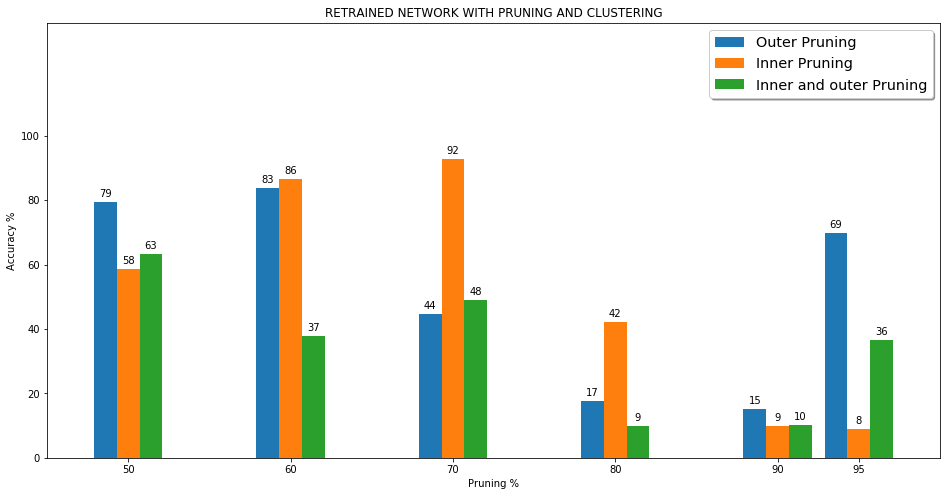

In [356]:
experiments_in = get_data_from_json('experiments/Pruning_KM_Inner.json')
experiments_out = get_data_from_json('experiments/Pruning_KM_Outer.json')
experiments_inout = get_data_from_json('experiments/Pruning_KM_InnerOuter.json') 

p = [int(e['connection'] * 100) for e in experiments_in['data']]
a_in = [e['accuracy'] * 100 for e in experiments_in['data']]
a_out = [e['accuracy'] * 100 for e in experiments_out['data']]
a_inout = [e['accuracy'] * 100 for e in experiments_inout['data']]

plt.figure(figsize=(16, 8))
w = 1.4
r1 = plt.bar(np.array(p)-w,a_out,width=w,label='Outer Pruning')
r2 = plt.bar(p,a_in,width=w,label='Inner Pruning')
r3= plt.bar(np.array(p)+w,a_inout,width=w,label='Inner and outer Pruning')
plt.axis([45, 100, 0, 135])
plt.xticks(p_out)
plt.yticks([0,20,40,60,80,100])
for rects in [r1,r2,r3]:
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.,height+1,'%d' % int(height),ha='center',va='bottom')
plt.xlabel('Pruning %')
plt.ylabel('Accuracy %')
plt.title('RETRAINED NETWORK WITH PRUNING AND CLUSTERING')
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('../../Pruning_Clustering.png')
plt.show()

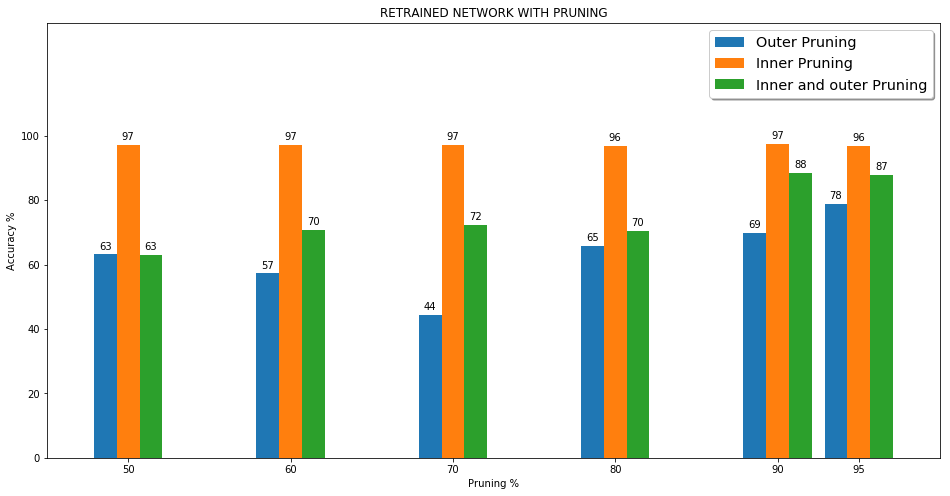

In [355]:
experiments_in = get_data_from_json('experiments/Pruning_Inner.json')
experiments_out = get_data_from_json('experiments/Pruning_Outer.json')
experiments_inout = get_data_from_json('experiments/Pruning_InnerOuter.json') 

p = [int(e['connection'] * 100) for e in experiments_in['data']]
a_in = [e['accuracy'] * 100 for e in experiments_in['data']]
a_out = [e['accuracy'] * 100 for e in experiments_out['data']]
a_inout = [e['accuracy'] * 100 for e in experiments_inout['data']]

plt.figure(figsize=(16, 8))
w = 1.4
r1 = plt.bar(np.array(p)-w,a_out,width=w,label='Outer Pruning')
r2 = plt.bar(p,a_in,width=w,label='Inner Pruning')
r3= plt.bar(np.array(p)+w,a_inout,width=w,label='Inner and outer Pruning')
plt.axis([45, 100, 0, 135])
plt.xticks(p_out)
plt.yticks([0,20,40,60,80,100])
for rects in [r1,r2,r3]:
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.,height+1,'%d' % int(height),ha='center',va='bottom')
plt.xlabel('Pruning %')
plt.ylabel('Accuracy %')
plt.title('RETRAINED NETWORK WITH PRUNING')
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('../../Pruning_Result.png')
plt.show()

In [392]:
a = [1,2,3,4]

[a[3]] + a[:2] + [a[1]] 

[4, 1, 2, 2]

In [402]:
a = [[[[[[[]]]]]]]


(1, 1)